In [61]:
# Импорт необходимых библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from urllib.parse import urlencode 
from scipy.stats import norm, mannwhitneyu, ttest_ind, shapiro, levene
import statsmodels.api as sm

%matplotlib inline

# Задача 1 — A/B-testing

## 1. Выгрузка данных

Так как данные находятся на платформе Яндекс.Диск, то воспользуемся библиотеками "requests" и "urllib" для того, чтобы получить ссылки на скачивание данных файлов и, в дальнейшем, преобразовать их в формат Датафрейма.

In [2]:
# 1.1 Создаем базовый URL

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

In [3]:
# 1.2 Создаем частный URL для каждой ссылки, предоставленной на платформе LMS

public_key_groups = 'https://disk.yandex.ru/d/58Us0DWOzuWAjg'
public_key_groups_add = 'https://disk.yandex.ru/d/3aARY-P9pfaksg'
public_key_active_studs = 'https://disk.yandex.ru/d/prbgU-rZpiXVYg'
public_key_checks = 'https://disk.yandex.ru/d/84hTmELphW2sqQ'

In [4]:
# 1.3 Соединяем предыдущие две части

final_url_groups = base_url + urlencode(dict(public_key=public_key_groups))
final_url_groups_add = base_url + urlencode(dict(public_key=public_key_groups_add))
final_url_active_studs = base_url + urlencode(dict(public_key=public_key_active_studs))
final_url_checks = base_url + urlencode(dict(public_key=public_key_checks))

In [5]:
# 1.4 Собственно создаем валидные ссылки для скачивания файлов

response_groups = requests.get(final_url_groups)
response_groups_add = requests.get(final_url_groups_add)
response_active_studs = requests.get(final_url_active_studs)
response_checks = requests.get(final_url_checks)

In [6]:
download_url_groups = response_groups.json()['href']
download_url_groups_add = response_groups_add.json()['href']
download_url_active_studs = response_active_studs.json()['href']
download_url_checks = response_checks.json()['href']

In [7]:
# 1.5 Считываем данные и преобразуем наши данные в формат пандасовского датафрейма

groups = pd.read_csv(download_url_groups, sep=';')
groups_add = pd.read_csv(download_url_groups_add)
active_studs = pd.read_csv(download_url_active_studs)
checks = pd.read_csv(download_url_checks, sep=';')

## 2. Предварительный анализ данных (EDA)

Перед тем, как приступить к решению задач, нужно удостовериться, что с нашими данными все в порядке. Для этого мы проведем предварительный анализ, то есть посмотрим, есть ли в наших данных пропущенные значения, дубликаты и т.д. Пройдемся по каждому файлу.

##### groups

In [8]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [9]:
groups.dtypes

id      int64
grp    object
dtype: object

In [10]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [11]:
groups.duplicated(subset=['id']).sum()

0

##### groups_add

In [12]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [13]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [14]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [15]:
groups_add.duplicated(subset=['id']).sum()

0

##### active_studs

In [16]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [17]:
active_studs.dtypes

student_id    int64
dtype: object

In [18]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [19]:
active_studs.duplicated().sum()

0

##### checks

In [20]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [21]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [22]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [23]:
checks.duplicated(subset=['student_id']).sum()

0

#### Вывод по EDA: 

В наших данных нет ни дубликатов пользователей, ни пропущенных значений, и формат данных соответствует нужному типу. Так что можно двигаться дальше!

## 3. Сбор данных в нужный вид

По условиям задачи, помимо основных данных (groups), у нас есть также дополнительные данные по пользователям (groups_add), которые пришли 2-мя днями позже. Это значит, что эти данные нужно объединить в одну таблицу.

После, у тех пользователей, которые зашли в день проведения эксперимента (active_studs) и сделали оплату (checks), мы должны узнать, к какой группе они принадлежат.

In [24]:
# 3.1 Соединяем таблицы "groups" и "groups_add"

whole_group = pd.concat([groups, groups_add], ignore_index=True)

In [25]:
whole_group.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [26]:
# 3.2 Объединяем предыдущую таблицу с таблицей пользователей, которые зашли в день проведения эксперимента

active_studs_with_groups = active_studs.merge(whole_group, 
                                  left_on='student_id',
                                  right_on='id',
                                  how='left')

active_studs_with_groups = active_studs_with_groups.drop('id', axis=1)

In [27]:
active_studs_with_groups.isna().sum()

student_id    0
grp           0
dtype: int64

In [28]:
# 3.3 Объединяем только что созданную таблицу с таблицей пользователей, которые сделали покупку в дни проведения эксперимента

paid_users = active_studs_with_groups.merge(checks, 
                                            on='student_id')

In [29]:
paid_users.head()

,student_id,grp,rev
0,1184303,A,1530.0000
1,3354191,B,1900.0001
2,3278734,B,1900.0000
3,720651,A,1980.0000
4,1232221,B,1900.0000


## 4. Подбор критерия

После того, как привели наши данные в нужный вид, мы должны определить нашу нулевую гипотезу и выбрать критерий оценки для нашего эксперимента.

Так как у нас есть данные по потраченной сумме от каждого пользователя, кто сделал покупку, мы можем проводить A/B-тест по данной метрике. То есть наша нулевая гипотеза будет состоять в том, что "средний чек пользователя из контрольной группы не отличается от среднего чека пользователя из тестовой группы". Тем самым, если наш p-value покажет результат меньше 5%, мы с 95%-й вероятностью сможем утверждать, что различия все-таки есть, и они статистически значимы. Значит, есть  смысл установки новой механики оплаты услуг на сайте.


Что касается критерия оценивания, у нас есть 3 варианта: t-тест, тест Манна-Уитни и bootstrap.

Для начала наши данные нужно разбить на две группы(выборки): тестовая/целевая (test_grp) и контрольная (control_grp). Дальше мы проверяем наши выборки на нормальность распределения и гомогенность дисперсий, чтобы понять, стоит ли нам здесь использовать t-тест Стьюдента.

Первым делом стоит взглянуть на соотношение наших значений.


In [30]:
paid_users.grp.value_counts()

B    314
A     78
Name: grp, dtype: int64

В наших данных больше пользователей из целевой группы, а общее количество — 392. Однако, это не является проблемой при использовании стат.критерия.

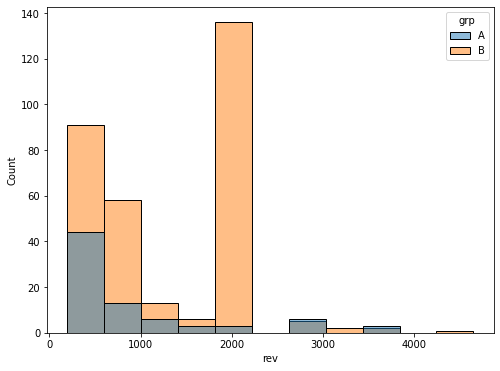

In [31]:
# 4.2 Построим гистограммы наших значений

plt.figure(figsize=(8,6))
sns.histplot(x='rev', data=paid_users, hue='grp')

Уже на гистограммах наших значений заметно, что ни в тестовой, ни в контрольной группах распределение не близко к нормальному, что уже ставит под сомнение выбор t-теста.

Утверждают, что при большой выборке данным требованием можно пренебречь. Однако, наших данных не так то много (392 наблюдений).

In [32]:
# 4.3 Создаем выборки с тестовой и контрольной группами

control_grp = paid_users[paid_users['grp'] == 'A'].rev
test_grp = paid_users[paid_users['grp'] == 'B'].rev

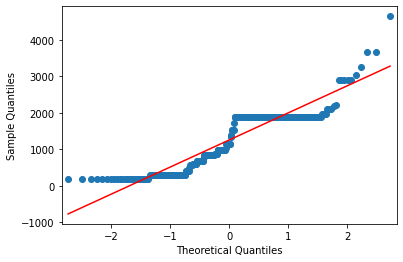

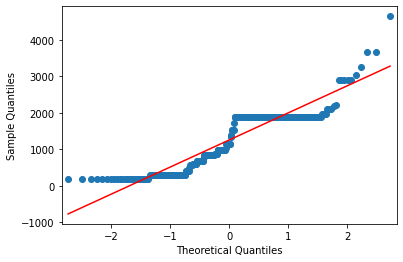

In [33]:
# 4.4 Построим график QQ-plot для двух выборок

sm.qqplot(test_grp, line='r')

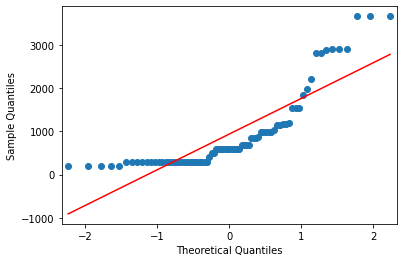

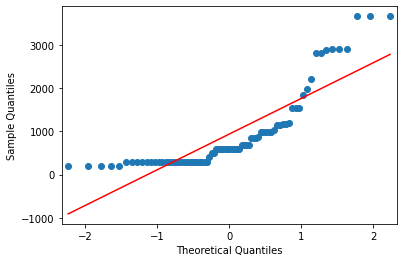

In [34]:
sm.qqplot(control_grp, line='r')

In [35]:
# 4.5 Посмотрим, что покажет тест Шапиро-Уилко на нормальность

print(shapiro(control_grp))
print(shapiro(test_grp))

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)
ShapiroResult(statistic=0.8547235727310181, pvalue=1.5437024585965894e-16)


Мы видим, что, как на графиках qq-plot, так и при тесте Шапиро, результаты ведут к тому, что распределения наших обоих выборок не близко к нормальному.

In [36]:
# 4.6 Проверим требование к гомогенности дисперсий

levene(control_grp, test_grp)

LeveneResult(statistic=3.0756816999816055, pvalue=0.08025675761347022)

Так как требования к t-тесту практически не соблюдаются, то целесообразно будет использовать либо непараметрический аналог t-теста, а именно критерий Манна-Уитни, либо Бутстрап.

Я бы предпочел использовать Бутстрап, так как, с точки зрения бизнеса, результат Манна-Уитни тяжело интерпретировать.

In [37]:
# 4.7 Напишем функцию Бутстрапа

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_iter = 2000, # количество бутстрап-выборок
    statistic = np.mean, # интересующая статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max(len(data_column_1), len(data_column_2))
    boot_data = []
    for i in range(boot_iter): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,
            replace=True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len,
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
    
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
    
    p_1 = norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data))
    
    p_2 = norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data))
    
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title('Histogram of boot_data')
    plt.show()
    
    return {'boot_data': boot_data,
            'ci': ci,
            'p_value': p_value}

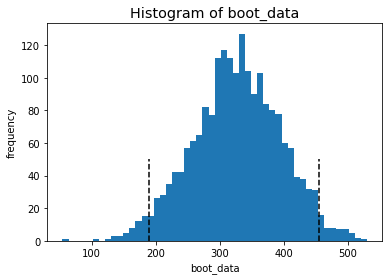

In [38]:
# 4.8 Инициализируем наш Бутстрап

boot_test = get_bootstrap(test_grp, control_grp, boot_iter=2000)

In [39]:
# 4.9 Посмотрим на наши доверительные интервалы

boot_test['ci']

,0
0.025,189.538466
0.975,455.097304


In [40]:
# 4.10 Взглянем на p-value

boot_test['p_value']

1.8758810733174813e-06

Так как p-значение значительно меньше 0.05 и в доверительные интервалы не входит 0, мы можем сказать, что различия в средних наших выборок есть и они стат.значимы.

Для интереса, так же взглянем на результат теста Манна-Уитни

In [41]:
# 4.11 Тест Манна-Уитни так же показывает стат.значимое различие

mannwhitneyu(control_grp, test_grp)

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

### Итог по задаче 1:

Мы провели предварительный анализ наших данных. В наших данных не было никаких дефектов, поэтому мы сразу приступили к следующей части. Мы обработали данные и привели их в нужный для нас вид. Дальше установили нулевую гипотезу.

Исходя из характеристик наших тестовых и контрольных групп, мы выявили, что t-тест может дать ненадежный результат, поэтому решили взять метод bootstrap. Как показал результат, p-value меньше 0.05 и значение 0 не входит в наш доверительный интервал, что с 95%-й уверенностью позволяет нам сказать, что между группами есть статистически значимые различия.

В результате, мы можем утвердить новую механику оплаты услуг на сайте и ожидать, что благодаря ней мы сможем увеличить средний чек пользователей. Возможно, на это повлияло новое внешнее оформление страницы оплаты (UI/UX дизайнеры поработали на славу!), либо благодаря нашим бэк-эндерам страница стала работать в разы быстрее, что уменьшило желание пользователей покидать страницу (причина может быть разная).


# Задача 2 — SQL

##### 2.1 Усердные ученики

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

In [62]:
"""
SELECT
    COUNT(*)
FROM
    (SELECT 
        st_id,
        SUM(correct)
    FROM peas
    WHERE
        toStartOfMonth(timest) == toStartOfMonth(now())
    GROUP BY
        st_id
    HAVING
        SUM(correct) >= 20)
"""

'\nSELECT\n    COUNT(*)\nFROM\n    (SELECT \n        st_id,\n        SUM(correct)\n    FROM peas\n    WHERE\n        toStartOfMonth(timest) == toStartOfMonth(now())\n    GROUP BY\n        st_id\n    HAVING\n        SUM(correct) >= 20)\n'

##### 2.2 Оптимизация воронки

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU

- ARPAU

- CR в покупку

- СR активного пользователя в покупку 

- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [60]:
'''
WITH (SELECT uniqExact(st_id) FROM studs) AS uniq_total_users_num,

     (SELECT 
        uniqExact(st_id) 
      FROM
          (SELECT
               st_id,
               SUM(correct) AS correct_answer_num
           FROM peas
           WHERE st_id IN (SELECT
                              DISTINCT(st_id)
                           FROM studs
                           )
           GROUP BY st_id
           HAVING correct_answer_num > 10
           )
     ) AS uniq_active_users_num,
    
    (SELECT
        uniqExact(st_id)
     FROM final_project_check
     WHERE st_id IN (SELECT
                         st_id
                     FROM
                         (SELECT
                             st_id,
                             SUM(correct) AS correct_answer_num
                          FROM peas
                          WHERE st_id IN (SELECT
                                             DISTINCT(st_id)
                                          FROM studs
                                          )
                          GROUP BY st_id
                          HAVING correct_answer_num > 10
                         )
                     )
    ) AS uniq_active_paid_users_num,
    
    (SELECT 
        uniqExact(st_id)
    FROM
        (SELECT
            st_id,
            SUM(correct) AS correct_math_answers_num
        FROM peas
        WHERE subject == 'Math' AND st_id IN (SELECT
                                                 DISTINCT(st_id)
                                              FROM studs)
        GROUP BY st_id
        HAVING correct_math_answers_num >= 2
        )
    ) AS uniq_active_math_users_num,
        
    (SELECT
        uniqExact(st_id)
    FROM final_project_check
    WHERE st_id in (SELECT
                        st_id
                    FROM
                        (SELECT
                            st_id,
                            SUM(correct) AS correct_math_answers_num
                         FROM peas
                         WHERE subject == 'Math' AND st_id in (SELECT
                                                                  DISTINCT(st_id)
                                                               FROM studs)
                         GROUP BY st_id
                         HAVING correct_math_answers_num >= 2))
        AND subject == 'Math'
    ) AS uniq_active_math_paid_users_num

SELECT
    ROUND(SUM(money) / uniq_total_users_num, 2) AS ARPU,
    ROUND(SUM(money) / uniq_active_users_num, 2) AS ARPAU,
    ROUND(uniqExact(st_id) / uniq_total_users_num, 4) AS CR,
    ROUND(uniq_active_paid_users_num / uniq_active_users_num, 4) AS CR_active,
    ROUND(uniq_active_math_paid_users_num / uniq_active_math_users_num, 4) AS CR_math_active
FROM final_project_check
'''

"\nWITH (SELECT uniqExact(st_id) FROM studs) AS uniq_total_users_num,\n\n     (SELECT \n        uniqExact(st_id) \n      FROM\n          (SELECT\n               st_id,\n               SUM(correct) AS correct_answer_num\n           FROM peas\n           WHERE st_id IN (SELECT\n                              DISTINCT(st_id)\n                           FROM studs\n                           )\n           GROUP BY st_id\n           HAVING correct_answer_num > 10\n           )\n     ) AS uniq_active_users_num,\n    \n    (SELECT\n        uniqExact(st_id)\n     FROM final_project_check\n     WHERE st_id IN (SELECT\n                         st_id\n                     FROM\n                         (SELECT\n                             st_id,\n                             SUM(correct) AS correct_answer_num\n                          FROM peas\n                          WHERE st_id IN (SELECT\n                                             DISTINCT(st_id)\n                                        

# Задача 3 — Python Function

##### Условие:

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

Реализуйте функцию, которая будет строить графики по получаемым метрикам.

##### Решение:

Перед решением данной задачи, хочется сделать пару допущений.

Во-первых, будем считать, что наш изначальный датафрейм, по которому были посчитаны наши показатели, была уже приведена в нужный вид (то есть в виде таблицы paid_users).

Во-вторых, раз мы использовали в изначальном варианте метод bootstrap, то внутри функции также будет считать по данному методу.

В-третьих, функция с построением графика будет объединена с первой функцией.

In [44]:
def update_metrics(initial_df, new_df):
    
    # Назначим переменные для названия столбцов новой таблицы 
    first_column, second_column = new_df.columns
    
    # Поменяем названия столбцов на случай, если заголовки будут другими
    new_df = new_df.rename(columns={first_column: 'id',
                                    second_column: 'grp'})
    
    # Сделаем преобразование, где выделим только тех пользователей, которые были в день эксперимента и сделали покупку
    active_studs_add_groups = active_studs.merge(new_df, 
                                  left_on='student_id',
                                  right_on='id')
    
    active_studs_add_groups = active_studs_add_groups.drop('id', axis=1)
    
    paid_add_users = active_studs_add_groups.merge(checks, 
                                            on='student_id')
    
    # Соединим наш новый датафрейм с предыдущим, по которому уже считали метрики
    final_df = pd.concat([initial_df, paid_add_users], ignore_index=True)
    
    # Снова разобъем наши данные на тестовую и контрольные выборки
    control_grp = final_df[final_df['grp'] == 'A'].rev
    test_grp = final_df[final_df['grp'] == 'B'].rev
    
    # Проведем bootstrap, который за одно и построит график
    boot_test = get_bootstrap(test_grp, control_grp, boot_iter=2000)
    
    # Вернем результат и график
    return boot_test

##### P.S.

В данной функции функцию "get_bootstrap" можно было бы прописать внутри, если бы она не была определена заранее или функция не была бы установлена в виде модуля.

Если бы нам давали только ссылку на Яндекс.Диск, то это также можно было бы прописать внутри функции, как это было прописано в начале этой юпитер файла. 